# Predictive time series RNNs:

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pickle

In [2]:
import unittests

## Generating the data

Let's begin by defining a bunch of helper functions to generate and plot the time series: 

In [3]:
def plot_series(time, series, format="-", start=0, end=None):
    """Plot the series"""
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(False)

def trend(time, slope=0):
    """A trend over time"""
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.1,
                    np.cos(season_time * 6 * np.pi),
                    2 / np.exp(9 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    """Adds noise to the series"""
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

These are the same you have been using in the previous assignments, so you will be generating the same time series data. You can do that with the following function:

In [4]:
def generate_time_series():
    """ Creates timestamps and values of the time series """
    
    # The time dimension or the x-coordinate of the time series
    time = np.arange(4 * 365 + 1, dtype="float32")

    # Initial series is just a straight line with a y-intercept
    y_intercept = 10
    slope = 0.005
    series = trend(time, slope) + y_intercept

    # Adding seasonality
    amplitude = 50
    series += seasonality(time, period=365, amplitude=amplitude)

    # Adding some noise
    noise_level = 3
    series += noise(time, noise_level, seed=51)
    
    return time, series

## Defining some useful global variables


`SPLIT_TIME`: time index to split between train and validation sets

`WINDOW_SIZE`: length od the window to use for smoothing the series

`BATCH_SIZE`: batch size for training the model

`SHUFFLE_BUFFER_SIZE`: number of elements from the dataset used to sample for a new shuffle of the dataset. For more information about the use of this variable you can take a look at the [docs](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#shuffle).


In [5]:
SPLIT_TIME = 1100
WINDOW_SIZE = 20
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 1000

Finally, put everything together and create the times series you will use for this assignment. You will save them in the global variables `TIME` and `SERIES`.

In [6]:
# Create the time series
TIME, SERIES = generate_time_series()

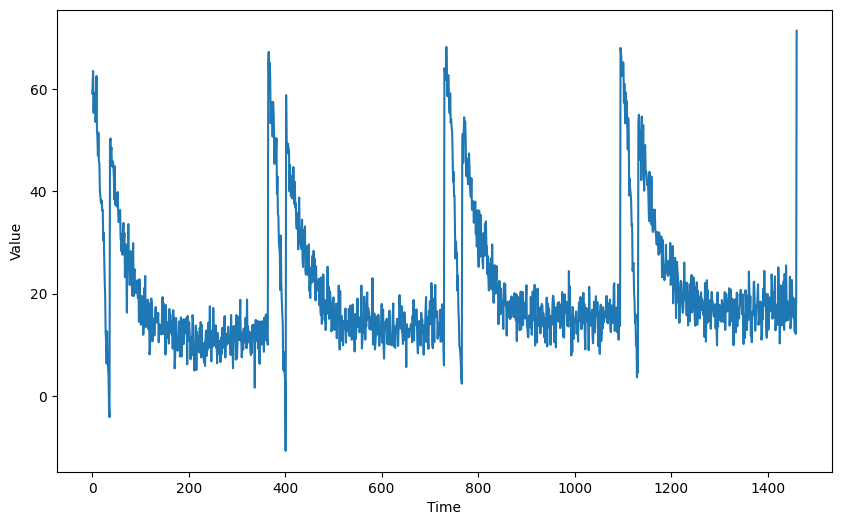

In [7]:
# Plot the generated series
plt.figure(figsize=(10, 6))
plot_series(TIME, SERIES)
plt.show()

## Processing the data


In [8]:
def train_val_split(time, series):
    """ Splits time series into train and validation sets"""
    time_train = time[:SPLIT_TIME]
    series_train = series[:SPLIT_TIME]
    time_valid = time[SPLIT_TIME:]
    series_valid = series[SPLIT_TIME:]

    return time_train, series_train, time_valid, series_valid

In [9]:
def windowed_dataset(series, window_size):
    """Creates windowed dataset"""
    series = tf.expand_dims(series, axis=-1)
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(SHUFFLE_BUFFER_SIZE)
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(BATCH_SIZE).prefetch(1)
    return dataset

Now, run the cell below to call these two functions and generate your training dataset:

In [10]:
# Split the dataset
time_train, series_train, time_valid, series_valid = train_val_split(TIME, SERIES)
# Apply the transformation to the training set
dataset = windowed_dataset(series_train, WINDOW_SIZE)

## Defining the model architecture

### create_uncompiled_model

In [12]:
# GRADED FUNCTION: create_uncompiled_model
def create_uncompiled_model():
    """Define uncompiled model

    Returns:
        tf.keras.Model: uncompiled model
    """
    model = tf.keras.models.Sequential([ 
        # Input layer with shape (WINDOW_SIZE, 1) for univariate time series data
        tf.keras.Input((WINDOW_SIZE, 1)),
        
        # LSTM layer wrapped in Bidirectional to allow learning in both directions
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=False)),
        
        # Dense layer for outputting a single value
        tf.keras.layers.Dense(1),
        
        # Lambda layer to scale the output
        tf.keras.layers.Lambda(lambda x: x * 200.0)  # Scale the output back to the range of the time series
    ]) 
    
    return model

In [13]:
# Define your uncompiled model
uncompiled_model = create_uncompiled_model()

# Check the parameter count against a reference solution
unittests.parameter_count(uncompiled_model)

Your model has 33,921 total parameters and the reference is 35,000. You are good to go!

Your model has 33,921 trainable parameters and the reference is 35,000. You are good to go!


In [14]:
example_batch = dataset.take(1)

try:
	predictions = uncompiled_model.predict(example_batch, verbose=False)
except:
	print("Your model is not compatible with the dataset you defined earlier. Check that the loss function and last layer are compatible with one another.")
else:
	print("Your current architecture is compatible with the windowed dataset! :)")
	print(f"predictions have shape: {predictions.shape}")

Your current architecture is compatible with the windowed dataset! :)
predictions have shape: (32, 1)


**Expected output:**

```
Your current architecture is compatible with the windowed dataset! :)
predictions have shape: (NUM_BATCHES, 1)
```
Where `NUM_BATCHES` is the number of batches you have set to your dataset.

In [15]:
# Test your code!
unittests.test_create_uncompiled_model(create_uncompiled_model)

 All tests passed!


As a last check, you can also print a summary of your model to see what the architecture looks like. This can be useful to get a sense of how big your model is.

In [16]:
uncompiled_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)   │ (None, 128)            │        33,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           129 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda (Lambda)                 │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33,921 (132.50 KB)

 Trainable params: 33,921 (132.50 KB)

 Non-trainable params: 0 (0.00 B)

## Adjusting the learning rate

In [17]:
def adjust_learning_rate(model):
    """Fit model using different learning rates

    Args:
        model (tf.keras.Model): uncompiled model

    Returns:
        tf.keras.callbacks.History: callback history
    """
    
    lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-6 * 10**(epoch / 20))
    
    # Select the optimizer (you can try Adam or SGD with momentum)
    optimizer = tf.keras.optimizers.Adam()  # Option 1: Adam optimizer
    # optimizer = tf.keras.optimizers.SGD(momentum=0.9)  # Option 2: SGD with momentum
    
    # Compile the model, using MSE as the loss function since we're doing regression
    model.compile(loss='mse', 
                  optimizer=optimizer, 
                  metrics=["mae"])  # Metrics include MAE for interpretability
    
    history = model.fit(dataset, epochs=100, callbacks=[lr_schedule])
    
    return history

In [18]:
# Run the training with dynamic LR
lr_history = adjust_learning_rate(uncompiled_model)

Epoch 1/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 2183.3699 - mae: 32.6835 - learning_rate: 1.0000e-06
Epoch 2/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2059.3975 - mae: 31.0199 - learning_rate: 1.1220e-06
Epoch 3/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2107.2300 - mae: 31.2986 - learning_rate: 1.2589e-06
Epoch 4/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1740.6838 - mae: 27.7229 - learning_rate: 1.4125e-06
Epoch 5/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2065.1455 - mae: 29.7253 - learning_rate: 1.5849e-06
Epoch 6/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1900.4280 - mae: 28.0175 - learning_rate: 1.7783e-06
Epoch 7/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1865.1942 - mae: 27.5996 - learning_rate: 1.9953e-06
Epoch 8/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1501.4519 - mae: 23.9577 - learning_rate: 2.2387e-06
Epoch 9/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1553.0629 - mae: 24.4200 - learning_rate: 2.5

Plot the achieved loss for each learning rate value, this way you can select an appropriate learning rate for your training.

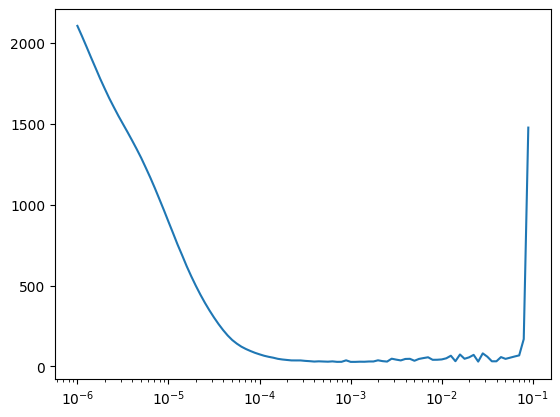

In [20]:
# Plot the loss for every LR
plt.semilogx(lr_history.history["learning_rate"], lr_history.history["loss"])
#plt.axis([1e-6, 1, 0, 30])

Based on this plot, which learning rate would you choose? You will get to use it on the next exercise.

## Compiling the model

In [21]:
# GRADED FUNCTION: create_model
def create_model():
    """Creates and compiles the model

    Returns:
        tf.keras.Model: compiled model
    """
    model = create_uncompiled_model()

    # Compile the model using Mean Squared Error (MSE) as the loss and Adam optimizer
    model.compile(loss='mse',  # Use MSE as the loss function for regression
                  optimizer=tf.keras.optimizers.Adam(),  # Adam optimizer
                  metrics=["mae"])  # Track MAE (Mean Absolute Error) for interpretability

    return model

In [22]:
# Create an instance of the model
model = create_model()

In [23]:
# Test your code!
unittests.test_create_model(create_model)

 All tests passed!


Now go ahead and train your model:

In [24]:
# Train it
history = model.fit(dataset, epochs=50)

Epoch 1/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 2285.7659 - mae: 37.3869
Epoch 2/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 96.2820 - mae: 6.8594 
Epoch 3/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 38.5852 - mae: 4.1751
Epoch 4/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 29.8952 - mae: 3.6565
Epoch 5/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 26.8375 - mae: 3.4558
Epoch 6/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 27.4125 - mae: 3.3997
Epoch 7/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 22.3629 - mae: 3.2673
Epoch 8/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 29.0717 - mae: 3.6147
Epoch 9/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 23.2489 - mae: 3.3336
Epoch 10/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 27.4288 - mae: 3.3530
Epoch 11/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 20.9415 - mae: 3.2012
Epoch 12/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 29.7244 - mae: 3.4629
Epoch 13/50
34/34 ━━━━━━━━━━━━━━━

Now go ahead and plot the training loss so you can monitor the learning process.

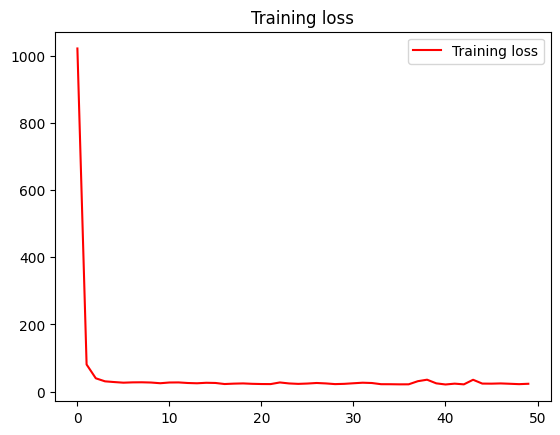

In [25]:
# Plot the training loss for each epoch

loss = history.history['loss']

epochs = range(len(loss))

plt.plot(epochs, loss, 'r', label='Training loss')
plt.title('Training loss')
plt.legend(loc=0)
plt.show()

## Evaluating the forecast

Now it is time to evaluate the performance of the forecast. For this you can use the `compute_metrics` function that you coded in a previous assignment:

In [26]:
def compute_metrics(true_series, forecast):
    """Computes MSE and MAE metrics for the forecast"""
    mse = tf.keras.losses.MSE(true_series, forecast)
    mae = tf.keras.losses.MAE(true_series, forecast)
    return mse, mae

In [27]:
def generate_forecast(model, series, window_size):
    """Generates a forecast using your trained model"""
    forecast = []
    for time in range(SPLIT_TIME, len(series)):
        pred = model.predict(series[time-window_size:time][np.newaxis])
        forecast.append(pred[0][0])
    return forecast

Now, run the cells below to generate and plot the forecast series:

In [28]:
# Save the forecast
rnn_forecast = generate_forecast(model, SERIES, WINDOW_SIZE)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━

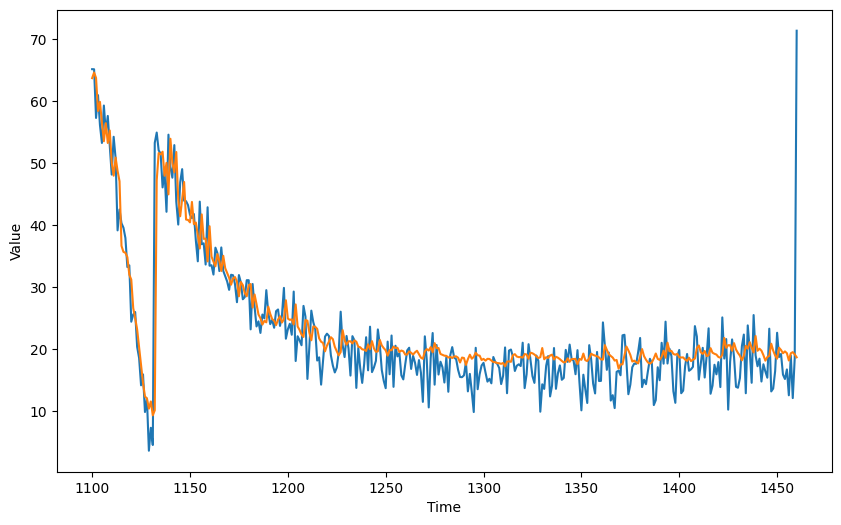

In [29]:
# Plot your forecast
plt.figure(figsize=(10, 6))

plot_series(time_valid, series_valid)
plot_series(time_valid, rnn_forecast)

Now use the `compute_metrics function` to find the MSE and MAE of your forecast. 

In [30]:
mse, mae = compute_metrics(series_valid, rnn_forecast)

print(f"mse: {mse:.2f}, mae: {mae:.2f} for forecast")

mse: 27.64, mae: 3.36 for forecast


In [31]:
# Save your mae in a pickle file
with open('forecast_mae.pkl', 'wb') as f:
    pickle.dump(mae.numpy(), f)